In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:

import os
os.chdir("..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/datasource_hackathon


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_folder = "data"
price_data = pd.read_csv(f"{data_folder}/Phase 0 - Price.csv")
sales_data = pd.read_csv(f"{data_folder}/Phase 0 - Sales.csv")
inventory_data = pd.read_csv(f"{data_folder}/Phase 0 - Inventory.csv")

In [5]:
# Let's merge the three datasets (price, sales, inventory) on common columns: 'Client', 'Warehouse', and 'Product'
# These columns are shared across the datasets, and we can merge them based on this common information.

# First, we need to reshape the data from wide format (with date columns) to long format for easier merging
price_data_melted = price_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Price')
sales_data_melted = sales_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Sales')
inventory_data_melted = inventory_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Inventory')

# Merge the datasets on 'Client', 'Warehouse', 'Product', and 'Date'
merged_data = pd.merge(price_data_melted, sales_data_melted, on=['Client', 'Warehouse', 'Product', 'Date'], how='outer')
merged_data = pd.merge(merged_data, inventory_data_melted, on=['Client', 'Warehouse', 'Product', 'Date'], how='outer')

# Convert 'Date' to datetime for easier time-based analysis
merged_data['Date'] = pd.to_datetime(merged_data['Date'])


In [6]:
merged_data = merged_data.sort_values(by=['Client', 'Warehouse', 'Product', 'Date'])

In [7]:
merged_data.head()

,Client,Warehouse,Product,Date,Price,Sales,Inventory
0,0,1,367,2020-07-06,10.900001,7.0,0.0
1,0,1,367,2020-07-13,10.900001,7.0,0.0
2,0,1,367,2020-07-20,10.900001,7.0,0.0
3,0,1,367,2020-07-27,15.582857,7.0,0.0
4,0,1,367,2020-08-03,27.289999,7.0,0.0


In [8]:
# merged_data = merged_data.drop(columns=['Client'],axis=1)

In [9]:
merged_data["id"] = (
    merged_data["Client"].astype(str)
    + "_"
    + merged_data["Warehouse"].astype("str")
    + "_"
    + merged_data["Product"].astype("str")
)

In [10]:
merged_data = merged_data.groupby(
    ["id", "Client", "Warehouse", "Product", "Date"], as_index=False
).agg({"Price": "mean", "Sales": "sum", "Inventory": "sum"})

In [11]:
merged_data.sort_values(by=["id", "Date"], inplace=True)

In [12]:
id_mindt_df = (
    merged_data.loc[merged_data["Price"].notnull()]
    .groupby("id", as_index=False)["Date"]
    .min()
)

In [13]:
id_mindt_df = id_mindt_df.rename(columns={"Date": "MinDate"})

In [14]:
id_mindt_df.head()

,id,MinDate
0,0_100_10705,2020-07-06
1,0_100_10789,2020-07-06
2,0_100_11015,2020-07-06
3,0_100_1149,2020-07-06
4,0_100_11526,2020-07-27


In [44]:
merged_data_new = pd.merge(merged_data, id_mindt_df, on=["id"], how="left")

In [45]:
merged_data_new.shape

(2559010, 9)

In [46]:
merged_data_new = merged_data_new.loc[merged_data_new["Date"] >= merged_data_new["MinDate"]].reset_index(drop=True)
print(merged_data_new.shape)

(1419748, 9)


In [48]:
merged_data_new["Price"] = merged_data_new["Price"].fillna(0.0)

#### id-Date min

In [18]:
combo_df = merged_data_new.groupby("id", as_index=False).agg({"Date": ["min", "max", "nunique"]})

In [19]:
# ravel the hierarchical columns into a single level
combo_df.columns = ["_".join(x) for x in combo_df.columns.ravel()]

In [20]:
combo_df.head()

,id_,Date_min,Date_max,Date_nunique
0,0_100_10705,2020-07-06,2023-10-02,170
1,0_100_10789,2020-07-06,2023-10-02,170
2,0_100_11015,2020-07-06,2023-10-02,170
3,0_100_1149,2020-07-06,2023-10-02,170
4,0_100_11526,2020-07-27,2023-10-02,167


In [49]:
merged_data_new = merged_data_new.sort_values(by=["id", "Date"]).reset_index(drop=True)

In [50]:
merged_data_new.head()

,id,Client,Warehouse,Product,Date,Price,Sales,Inventory,MinDate
0,0_100_10705,0,100,10705,2020-07-06,17.289999,7.0,0.0,2020-07-06
1,0_100_10705,0,100,10705,2020-07-13,17.289999,7.0,0.0,2020-07-06
2,0_100_10705,0,100,10705,2020-07-20,17.289999,7.0,0.0,2020-07-06
3,0_100_10705,0,100,10705,2020-07-27,16.570000,7.0,0.0,2020-07-06
4,0_100_10705,0,100,10705,2020-08-03,14.770000,7.0,0.0,2020-07-06


In [51]:
## Next Steps: ID level (warehouse + product)
# 1. Id level make the data continous weekly - every id should have all the weeks starting from the min date to max date
# 2. Fill missing values with 0/mean (Price , sales , inventory)
# 3. For every id we have to add 13 weeks of artificial index
# 4. For inventory we need to have some different approach to be used with markers columns
#5. Create rules for the categorizing ids into Regular , Irregualar , Intermittent demand patterns based on sales data

In [24]:
# create weekly data for  max time time period plus 13 weeks extra
print(merged_data_new["Date"].min()), print(merged_data_new["Date"].max())

2020-07-06 00:00:00
2023-10-02 00:00:00


(None, None)

In [25]:
weekly_data = pd.DataFrame(
    pd.date_range(
        start=merged_data_new["Date"].min(),
        end=merged_data_new["Date"].max() + pd.DateOffset(weeks=13),
        freq="W-MON",
    ),
    columns=["Date"],
)

In [26]:
weekly_data['marker_key'] = 1

In [27]:
#regular date features
weekly_data["Year"] = weekly_data["Date"].dt.year
weekly_data["Month"] = weekly_data["Date"].dt.month
weekly_data["WeekOfYear"] = weekly_data["Date"].dt.isocalendar().week
weekly_data["DayOfMonth"] = weekly_data["Date"].dt.day
weekly_data["Quarter"] = weekly_data["Date"].dt.quarter
weekly_data["DayOfWeek"] = weekly_data["Date"].dt.dayofweek
weekly_data["IsWeekend"] = weekly_data["DayOfWeek"].isin([5, 6]).astype(int)

# Create sin and cos features
weekly_data["Month_sin"] = np.sin(2 * np.pi * weekly_data["Month"] / 12)
weekly_data["Month_cos"] = np.cos(2 * np.pi * weekly_data["Month"] / 12)
weekly_data["WeekOfYear_sin"] = np.sin(2 * np.pi * weekly_data["WeekOfYear"] / 52)
weekly_data["WeekOfYear_cos"] = np.cos(2 * np.pi * weekly_data["WeekOfYear"] / 52)

In [95]:
def categorize_month_period(date):
    day = date.day
    if day <= 10:
        return "Month_Start"
    elif day <= 20:
        return "Month_Middle"
    else:
        return "Month_End"


# Apply the function to create a new column 'month_period'
weekly_data["month_period"] = weekly_data["Date"].apply(categorize_month_period)

In [96]:
weekly_data.head()

,Date,marker_key,Year,Month,WeekOfYear,DayOfMonth,Quarter,DayOfWeek,IsWeekend,Month_sin,Month_cos,WeekOfYear_sin,WeekOfYear_cos,month_period
0,2020-07-06,1,2020,7,28,6,3,0,0,-0.500000,-0.866025,-0.239316,-0.970942,Month_Start
1,2020-07-13,1,2020,7,29,13,3,0,0,-0.500000,-0.866025,-0.354605,-0.935016,Month_Middle
2,2020-07-20,1,2020,7,30,20,3,0,0,-0.500000,-0.866025,-0.464723,-0.885456,Month_Middle
3,2020-07-27,1,2020,7,31,27,3,0,0,-0.500000,-0.866025,-0.568065,-0.822984,Month_End
4,2020-08-03,1,2020,8,32,3,3,0,0,-0.866025,-0.500000,-0.663123,-0.748511,Month_Start


In [29]:
df1 = merged_data_new.drop_duplicates(subset=["id"], keep="first").reset_index(
    drop=True
)[["id", "Client", "Warehouse", "Product"]]
df1["marker_key"] = 1
df2 = weekly_data.drop_duplicates(subset=["Date"], keep="first").reset_index(drop=True)[
    ["Date", "marker_key"]
]
df3 = df1.merge(df2, on="marker_key", how="outer").drop("marker_key", axis=1)

In [30]:
df3.sort_values(by=["id", "Date"], inplace=True)

In [35]:
df1.shape # total combinations

(15053, 5)

In [36]:
df3.head()

,id,Client,Warehouse,Product,Date
0,0_100_10705,0,100,10705,2020-07-06
1,0_100_10705,0,100,10705,2020-07-13
2,0_100_10705,0,100,10705,2020-07-20
3,0_100_10705,0,100,10705,2020-07-27
4,0_100_10705,0,100,10705,2020-08-03


In [52]:
merged_data_new_2 = pd.merge(
    merged_data_new,
    df3,
    on=["id", "Client", "Warehouse", "Product", "Date"],
    how="outer",
)

In [53]:
merged_data_new_2 = merged_data_new_2.sort_values(by=["id", "Date"]).reset_index(drop=True)

In [55]:
merged_data_new_2.loc[
    (merged_data_new_2["Sales"].isnull())
    & (merged_data_new_2["Date"] <= merged_data_new["Date"].max())
].head()

,id,Client,Warehouse,Product,Date,Price,Sales,Inventory,MinDate
732,0_100_11526,0,100,11526,2020-07-06,NaN,NaN,NaN,NaT
733,0_100_11526,0,100,11526,2020-07-13,NaN,NaN,NaN,NaT
734,0_100_11526,0,100,11526,2020-07-20,NaN,NaN,NaN,NaT
1281,0_100_14311,0,100,14311,2020-07-06,NaN,NaN,NaN,NaT
1282,0_100_14311,0,100,14311,2020-07-13,NaN,NaN,NaN,NaT


In [58]:
merged_data_new_2["MinDate"] = merged_data_new_2.groupby("id")["MinDate"].transform(
    lambda x: x.fillna(x.min())
)

In [61]:
merged_data_new_2.isnull().sum()

id                 0
Client             0
Warehouse          0
Product            0
Date               0
Price        1334951
Sales        1334951
Inventory    1334951
MinDate            0
dtype: int64

In [62]:
merged_data_new_2 = (
    merged_data_new_2.loc[merged_data_new_2["Date"] >= merged_data_new_2["MinDate"]]
    .reset_index(drop=True)
    .drop(columns=["MinDate"], axis=1)
)

In [65]:
merged_data_new_2["Tag"] = np.where(
    merged_data_new_2["Date"] > merged_data_new["Date"].max(), "Test", "Train"
)

In [68]:
# no blanks for continuous weekly data in train
merged_data_new_2.loc[merged_data_new_2["Tag"] == "Train"].isnull().sum()

id           0
Client       0
Warehouse    0
Product      0
Date         0
Price        0
Sales        0
Inventory    0
Tag          0
dtype: int64

In [69]:
merged_data_new_2.shape

(1615437, 9)

In [70]:
# testing blanks with 0.0
merged_data_new_2[["Price", "Sales", "Inventory"]] = merged_data_new_2[
    ["Price", "Sales", "Inventory"]
].fillna(0.0)

In [ ]:
# merged_data_new == merged_data_new_2 with only train data

In [ ]:
# Some data on inventory

In [73]:
merged_data_new.head()

,id,Client,Warehouse,Product,Date,Price,Sales,Inventory,MinDate
0,0_100_10705,0,100,10705,2020-07-06,17.289999,7.0,0.0,2020-07-06
1,0_100_10705,0,100,10705,2020-07-13,17.289999,7.0,0.0,2020-07-06
2,0_100_10705,0,100,10705,2020-07-20,17.289999,7.0,0.0,2020-07-06
3,0_100_10705,0,100,10705,2020-07-27,16.570000,7.0,0.0,2020-07-06
4,0_100_10705,0,100,10705,2020-08-03,14.770000,7.0,0.0,2020-07-06


In [97]:
inventory_df = (
    merged_data_new[["id", "Date", "Inventory"]]
    .sort_values(by=["id", "Date"])
    .reset_index(drop=True)
)

inventory_df = pd.merge(
    inventory_df,
    weekly_data[["Date", "Month", "WeekOfYear", "month_period"]],
    how="left",
    on="Date",
)

In [99]:
inventory_df.head()

,id,Date,Inventory,Month,WeekOfYear,month_period,inventory_category
0,0_100_10705,2020-07-06,0.0,7,28,Month_Start,Low
1,0_100_10705,2020-07-13,0.0,7,29,Month_Middle,Low
2,0_100_10705,2020-07-20,0.0,7,30,Month_Middle,Low
3,0_100_10705,2020-07-27,0.0,7,31,Month_End,Low
4,0_100_10705,2020-08-03,0.0,8,32,Month_Start,Low


In [100]:
# Define thresholds for inventory levels (customize as needed)
def categorize_inventory(x):
    if x <= 1:
        return "Low"
    elif x <= 3:
        return "Medium"
    else:
        return "High"


# Create inventory category column
inventory_df["inventory_category"] = inventory_df["Inventory"].apply(
    categorize_inventory
)

In [103]:
inventory_df.head()

,id,Date,Inventory,Month,WeekOfYear,month_period,inventory_category
0,0_100_10705,2020-07-06,0.0,7,28,Month_Start,Low
1,0_100_10705,2020-07-13,0.0,7,29,Month_Middle,Low
2,0_100_10705,2020-07-20,0.0,7,30,Month_Middle,Low
3,0_100_10705,2020-07-27,0.0,7,31,Month_End,Low
4,0_100_10705,2020-08-03,0.0,8,32,Month_Start,Low


In [105]:
monthly_inventory_markers = inventory_df.groupby(["id", "Month"], as_index=False)[
    ["inventory_category"]
].agg(lambda x: x.mode()[0])

weekly_inventory_markers = inventory_df.groupby(["id", "WeekOfYear"], as_index=False)[
    ["inventory_category"]
].agg(lambda x: x.mode()[0])

monthly_period_inventory_markers = inventory_df.groupby(
    ["id", "month_period"], as_index=False
)[["inventory_category"]].agg(lambda x: x.mode()[0])

In [106]:
# we have 11171 client product combinations

In [107]:
monthly_inventory_markers.shape, weekly_inventory_markers.shape, monthly_period_inventory_markers.shape

((156628, 3), (658672, 3), (44895, 3))

In [109]:
monthly_period_inventory_markers.head()

,id,month_period,inventory_category
0,0_100_10705,Month_End,Low
1,0_100_10705,Month_Middle,Low
2,0_100_10705,Month_Start,Low
3,0_100_10789,Month_End,Low
4,0_100_10789,Month_Middle,Low


In [ ]:
# demand wise categorization of sales

In [177]:
# Function to categorize based on frequency and variability
def categorize_demand(demand_series):
    non_zero_weeks = (demand_series > 0).sum()
    total_weeks = len(demand_series)

    # Calculate frequency of demand
    demand_frequency = non_zero_weeks / total_weeks

    # Calculate variability (CV: Coefficient of Variation)
    demand_variability = (
        demand_series.std() / demand_series.mean() if demand_series.mean() > 0 else 0
    )

    # Logic to categorize demand patterns
    if demand_frequency > 0.6 and demand_variability < 0.5:
        return "Regular"
    elif demand_frequency > 0.5 and demand_variability >= 0.5:
        return "Irregular"
    else:
        return "Intermittent"

In [178]:
df_sales_demand = (
    merged_data_new.groupby(["id"], as_index=False)["Sales"]
    .agg(list)
    .reset_index(drop=True)
)

df_sales_demand["demand_category"] = (
    df_sales_demand["Sales"]
    .apply(lambda x: categorize_demand(np.array(x)))
    .drop(columns=["Sales"], axis=1)
)

In [179]:
df_sales_demand.head()

,id,Sales,demand_category
0,0_100_10705,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...",Irregular
1,0_100_10789,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....",Regular
2,0_100_11015,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...",Irregular
3,0_100_1149,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...",Irregular
4,0_100_11526,"[2.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...",Irregular


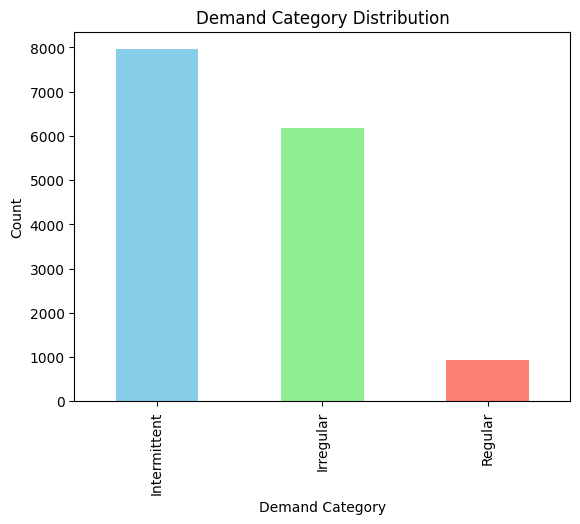

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame is already defined as df_sales_demand with 'demand_category' column
# Count occurrences of each category
category_counts = df_sales_demand['demand_category'].value_counts()

# Create bar plot
category_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

# Add labels and title
plt.xlabel('Demand Category')
plt.ylabel('Count')
plt.title('Demand Category Distribution')

# Show plot
plt.show()


In [181]:
df_sales_demand['demand_category'].value_counts()

demand_category
Intermittent    7958
Irregular       6169
Regular          926
Name: count, dtype: int64

In [182]:

# Select a few unique ids for each demand category
regular_ids = df_sales_demand[df_sales_demand['demand_category'] == 'Regular']['id'].unique()[:10]
irregular_ids = df_sales_demand[df_sales_demand['demand_category'] == 'Irregular']['id'].unique()[:10]
intermittent_ids = df_sales_demand[df_sales_demand['demand_category'] == 'Intermittent']['id'].unique()[:10]

print('Regular Demand IDs:', regular_ids)
print('Irregular Demand IDs:', irregular_ids)
print('Intermittent Demand IDs:', intermittent_ids)

Regular Demand IDs: ['0_100_10789' '0_100_3463' '0_100_4431' '0_100_655' '0_100_7186'
 '0_100_8011' '0_120_5604' '0_121_10705' '0_121_11000' '0_121_1149']
Irregular Demand IDs: ['0_100_10705' '0_100_11015' '0_100_1149' '0_100_11526' '0_100_11983'
 '0_100_12171' '0_100_14311' '0_100_1969' '0_100_3234' '0_100_3515']
Intermittent Demand IDs: ['0_120_1149' '0_120_11552' '0_120_11983' '0_120_12171' '0_120_14160'
 '0_120_14311' '0_120_1485' '0_120_3463' '0_120_367' '0_120_7457']


In [183]:
import matplotlib.pyplot as plt

# Function to plot Date vs. Sales for a given id
def plot_date_sales(ax, df_subset, title):
    ax.plot(df_subset['Date'], df_subset['Sales'], marker='o')
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.grid(True)

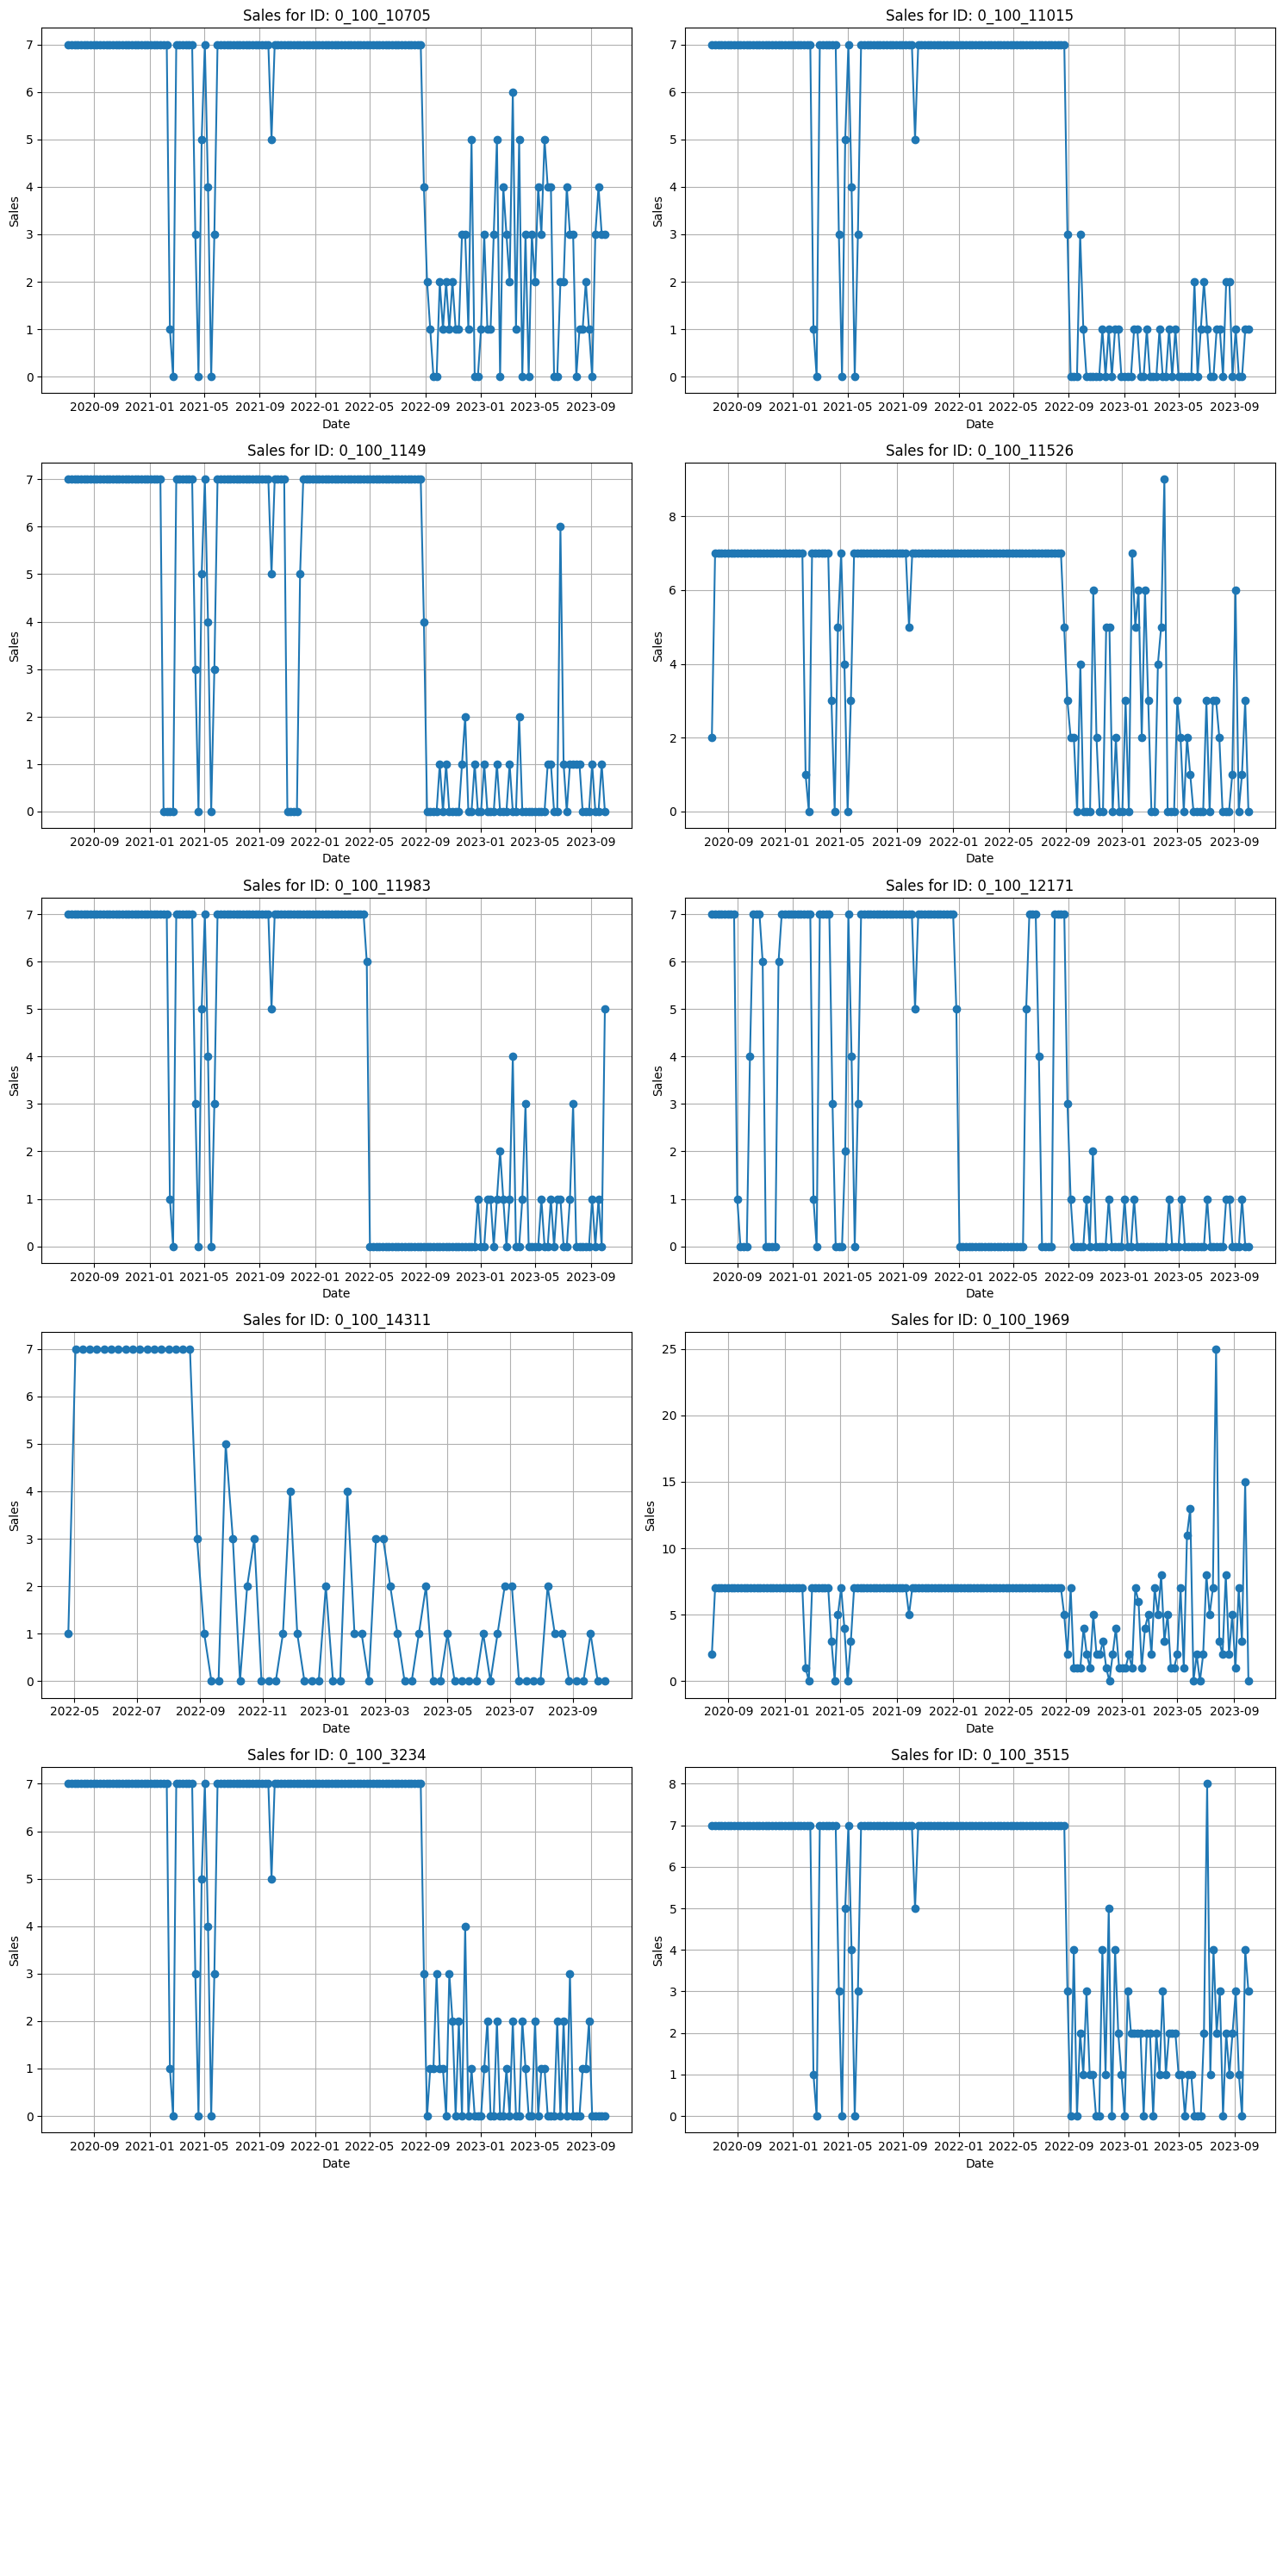

In [184]:
# Set up figure and axes
num_plots = len(irregular_ids)
fig_size = (15, 5 * ((num_plots // 2) + 1))  # Adjust height based on number of plots
fig, axs = plt.subplots((num_plots // 2) + 1, 2, figsize=fig_size)
axs = axs.flatten()  # Flatten to make indexing easier

# Plot for each ID
for idx, id_value in enumerate(irregular_ids):
    df_subset = merged_data_new[merged_data_new["id"] == id_value]
    ax = axs[idx]
    plot_date_sales(ax, df_subset, f"Sales for ID: {id_value}")

# Hide any unused subplots
for idx in range(len(irregular_ids), len(axs)):
    axs[idx].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# So we are writting out 
# merged_data_new_2, weekly_data, monthly_inventory_markers, weekly_inventory_markers, monthly_period_inventory_markers, df_sales_demand

In [185]:
os.makedirs("processed_data", exist_ok=True)
merged_data_new_2.to_pickle("processed_data/merged_data_new_2.pkl")
weekly_data.to_pickle("processed_data/weekly_data.pkl")
monthly_inventory_markers.to_pickle("processed_data/monthly_inventory_markers.pkl")
weekly_inventory_markers.to_pickle("processed_data/weekly_inventory_markers.pkl")
monthly_period_inventory_markers.to_pickle(
    "processed_data/monthly_period_inventory_markers.pkl"
)
df_sales_demand.to_pickle("processed_data/df_sales_demand.pkl")

################################################# end of script ##########################################################
```